In [586]:
import numpy as np 
import scipy
import matplotlib.pyplot as plt 
from sklearn.datasets import load_iris
import pandas as pd
from seaborn import pairplot
from typing import Tuple

# Exercise 3: Gaussian Mixture Model EM-Algorithm

In this notebook we will implement the EM-Algorithm for GMMs and apply it to "real" dataset: Iris. This is perhaps the best known dataset in the pattern recognition literature. The data set contains 3 classes of 50 instances each, where each class refers to a type of iris plant. The are four features, the sepal length in cm the sepal width in cm, the petal length in cm and the petal width in cm. 

The latter two cells will load the dataset into the notebook.

In [587]:
# Data as dataframe
data = load_iris(as_frame=True)

df_X = data["data"]
df_y = data["target"]

# Train data in numpy arrays
X = df_X.to_numpy()
y = df_y.to_numpy()

# Dataset in a df for plotting
df = pd.concat([df_X, df_y], 1)

C:\Users\manug\AppData\Local\Temp\ipykernel_15800\1947761488.py:12: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df = pd.concat([df_X, df_y], 1)


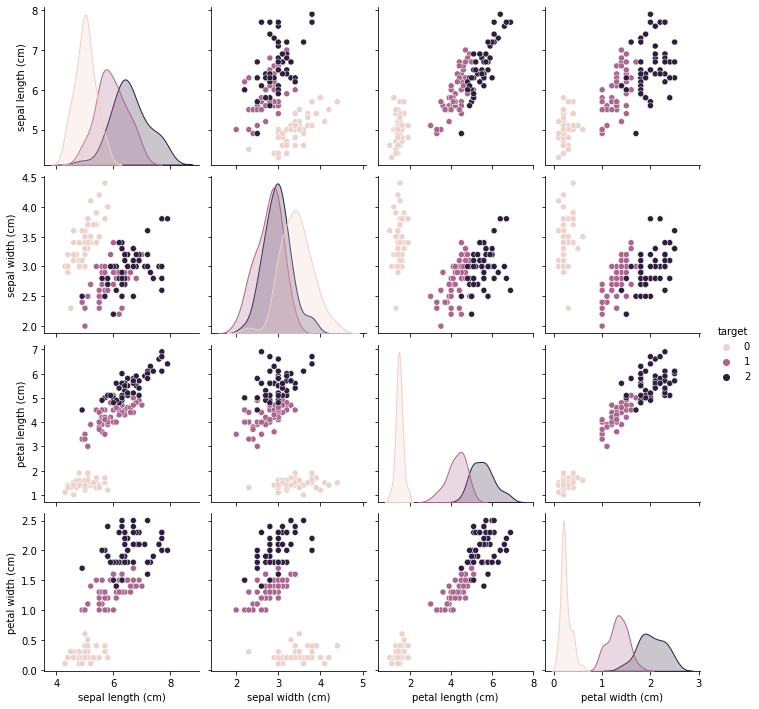

In [588]:
pairplot(df, hue="target")

Based on the above pairplot one can already guess that a Gaussian Mixture model can nicely model this data, so let's do that!

## Exercise 3.1

Here we will implement the E-step and M-step as a function. You already derived all the formulas for the EM algorithm by yourself in Exercise 2. Here are the solutions you should have arrived at:

### E-step

This requires to compute
$$ \gamma (k) = \frac{\pi_k^{old} \mathcal{N}(x_n; \mu_k^{old}, \Sigma_k^{old})}{\sum_{k=1}^K \pi_k^{old} \mathcal{N}(x_n; \mu_k^{old}, \Sigma_k^{old})} \qquad N_k = \sum_{i=1}^N \gamma(k)$$
for each datapoint. This equals the posterior probabilities of cluster assignments given the current parameter candidates. 

**NOTE**: For numerical statbility, you may want to perform most computations in log-space and perform normalization using the "logsumexp" trick (i.e. using np.logsumexp). 

### M-step 

$$ \pi_k = \frac{N_k}{N} \qquad \mu_k = \frac{1}{N_k}\sum_{i=1}^N \gamma(k)x_i \qquad \Sigma_k = \frac{1}{N_k} \sum_{i=1}^n \gamma(k)(x-\mu_k) (x-\mu_k)^T$$

In [721]:
# Some variables you may want to use
N = X.shape[0]
d = X.shape[1]

# Here we know the number of clusters, there are only 3 types of iris plants in the data.
K = 3

In [949]:

def E_step(X, pi, mu, cov) -> np.array:
    # Your code here ...
    gamma = np.zeros((N,K))
    for k in range(K):  
            gamma[:,k] = np.clip(scipy.stats.multivariate_normal.logpdf(X,mu[k], cov[k]) + np.log(pi[k]), -50, 50)

    # Stable normalization
    gamma -= scipy.special.logsumexp(gamma, axis=-1).reshape(-1,1)
    return np.exp(gamma)

In [950]:
# Test for correctness
test1 = E_step(X, np.array([1/3, 1/3, 1/3]), np.ones((3,4)), [np.eye(4) for k in range(3)])
test2 = E_step(X, np.array([1/3, 1/3, 1/3]), np.array([[-1.,0.,3., 0.], [0.,2.,0., 1.], [5.,5.,5.,5.]]), [np.eye(4) for k in range(3)])

assert np.isclose(test1.mean(0), np.array([1/3, 1/3, 1/3]), atol=1e-2, rtol=1e-2).all(), "Test1 failed"
assert np.isclose(test2.mean(0), np.array([2.93392254e-05, 2.85799805e-01, 7.14170855e-01]), atol=1e-2, rtol=1e-2).all(), "Test2 failed"

In [991]:
def M_step(gammas, X) -> Tuple[np.array, np.array, np.array]:
    # Your code here
    N_k = gammas.sum(0) 
    pi = N_k/N
    mu = 1/N_k.reshape(K, 1)*(gammas.reshape(N, K, 1)*X.reshape(N, 1, d)).sum(0)
    covs = []
    for k in range(K):
        r = gammas[:, k, None]*(X-mu[k])
        outer = r.T@r + np.eye(4)*1e-3
        covs.append(1/N_k[k] * outer)

    return pi, mu, np.stack(covs)

In [992]:
# Test for correctness
pi_test1, mu_test1, cov_test1 = M_step(test1, X)
assert np.isclose(pi_test1, np.array([1/3, 1/3, 1/3]), atol=1e-2, rtol=1e-2).all() and np.isclose(mu_test1.mean(0), np.array([5.84333333, 3.05733333, 3.758     , 1.19933333]), atol=1e-2, rtol=1e-2).all() and np.isclose(cov_test1.mean(), 0.20193908333333374, atol=1e-2, rtol=1e-2) , "Test1 failed"

## Exercise 3.2 

While not required for the algorithm, it is a good idea to compute the total data loglikelihood. Recall that for a Gaussian Mixture model this is given by

$$ p(x) = \sum_{k=1}^K \pi_k \mathcal{N}(x; \mu_k, \Sigma_k) $$

**NOTE**: As we saw in the EXAMple question each iteration must decrease the negative loglikelihood.

In [993]:
def negativeloglikelihood(X, pi, mu, cov) -> float:
    # Your code here
    ll = 0. 
    for k in range(K):
        ll += scipy.stats.multivariate_normal.pdf(X, mu[k], cov[k])*pi[k]
    logll = np.log(ll).mean(0)
    return -logll

In [994]:
# Test for correctness
#assert np.isclose(negativeloglikelihood(X, pi_test1, mu_test1, cov_test1), 8.73710080633158), "Test failed"

## Exercise 3.3

Implement a random initialization scheme. As you learned in the lecture, EM will only converge to a **local** minima. Thus to find a good solution you should implement a good initialization.

**NOTE**: Some parameters have constraints that the initialization should satisfy!

In [1009]:
def init_params():
    # Your code here
    pi = np.random.dirichlet(10*np.ones(K))
    mu = np.random.normal(5, 2, (K, d))
    cov = []
    for k in range(K):
        std = np.random.normal(0, 0.5, (d,d))
        cov.append(np.eye(4)*2 + std.T@std)
    cov = np.array(cov)
    return pi, mu, cov

## Exercise 3.5

Implement the EM algorithm using the function above. Run it once. (Maybe we skip this and directly go to the next point...)

In [1010]:
def fit(pi, mu, cov, iters=100):
    loss_hist = []
    for i in range(iters):
        g = E_step(X, pi, mu, cov)
        pi, mu, cov = M_step(g, X)
        loss = negativeloglikelihood(X, pi, mu, cov)
        loss_hist.append(loss)
    return pi, mu, cov, loss_hist

In [1011]:
pi, mu, cov, loss = fit(*init_params())

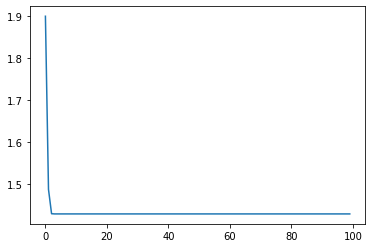

In [1012]:
plt.plot(loss)

## Exercise 3.6

Run your algorithm 200 times on different initializations. Pick the parameters which minimize the negative log likelihood and plot the negative loglikelihood for each run. Comment if the results match your expectations.

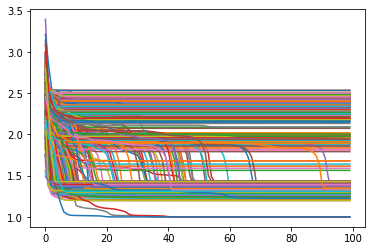

In [1013]:
best_pi, best_mu, best_cov = None, None, None

best_loss = np.inf
for i in range(500):
    pi, mu, cov, loss = fit(*init_params())
    if loss[-1] < best_loss:
        best_pi, best_mu, best_cov = pi, mu, cov

    plt.plot(loss)

## Exercise 3.7

Note that for now, we did not use the labels $y$. This is because our model is unsupervised, we assume there is an underlying "clustered" structure but pretend we don't know it. This raises the question if we did recover the ground truth labels.

To test this predict the most cluster assignment for the data.

**NOTE** You already implemented the functions you require to do this

In [1014]:
# Your code here
probs = E_step(X, best_pi, best_mu, best_cov)
predictions = probs.argmax(-1)

# The predictions should be an array of length N containing either 0,1 or 2.
df["predictions"] = predictions

C:\Users\manug\AppData\Local\Temp\ipykernel_15800\2939715871.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  pairplot(df.drop("target", 1), hue="predictions")


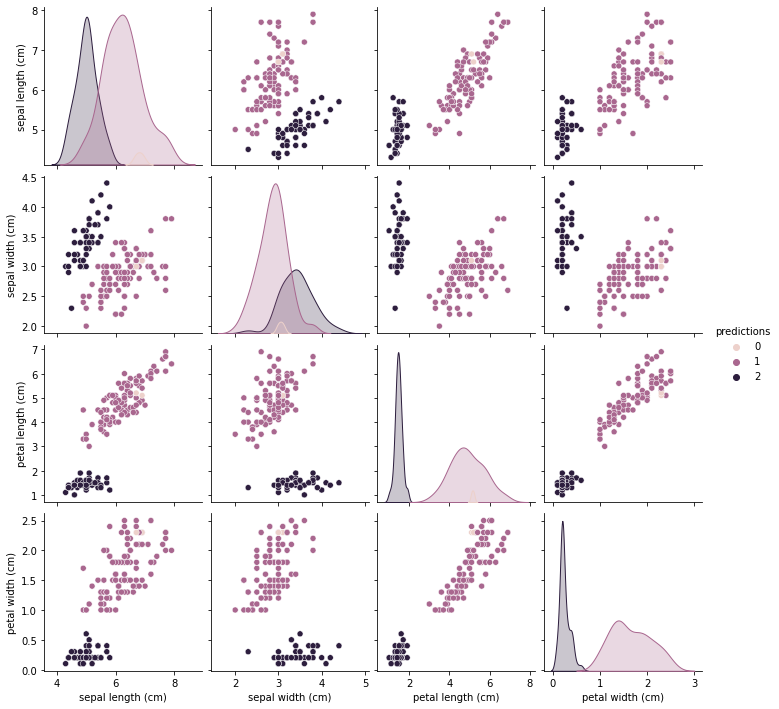

In [1015]:
pairplot(df.drop("target", 1), hue="predictions")

You can compare your results with the plot above. Does it recovered the truth? If not give some reasons why the approach may failed:

Some reasons...